In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import pyarrow.parquet as pq
import scipy.stats
import warnings

from s3fs.core import S3FileSystem
from bs4 import BeautifulSoup
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from scipy import stats
from scipy.sparse import hstack

warnings.filterwarnings('ignore')

In [3]:
def read_parquet_from_s3(key):
    return pq.ParquetDataset('s3://spark-lrng-d.sei/{}'.format(key), filesystem=S3FileSystem(anon=False)).read_pandas().to_pandas()

def read_csv_from_s3(key, header=0, engine='python'):
    return pd.read_csv('s3://spark-lrng-d.sei/{}'.format(key),  header=0, engine='python', encoding='ISO-8859-1')

#### Data Fields
<b>id</b> - Id


<b>OwnerUserId</b> - Id of user, who answered the question 


<b>Parent</b>- Id of question, the answer belongs to


<b>Score</b> - Score(target variable)

In [4]:
%%time
answers_df = read_csv_from_s3('data/Answers.csv')

CPU times: user 26.8 s, sys: 14.4 s, total: 41.1 s
Wall time: 21min 6s


In [5]:
answers_df.describe()

,Id,OwnerUserId,ParentId,Score
count,9.871220e+05,9.817550e+05,9.871220e+05,987122.000000
mean,2.160744e+07,1.589642e+06,2.053496e+07,3.028437
std,1.179488e+07,1.649346e+06,1.195486e+07,21.263246
min,4.970000e+02,1.000000e+00,4.690000e+02,-38.000000
25%,1.144775e+07,2.603030e+05,9.968532e+06,0.000000
50%,2.254188e+07,9.634650e+05,2.103550e+07,1.000000
75%,3.205469e+07,2.433810e+06,3.115233e+07,3.000000
max,4.014337e+07,7.044747e+06,4.014319e+07,8384.000000


In [7]:
answers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 987122 entries, 0 to 987121
Data columns (total 6 columns):
Id              987122 non-null int64
OwnerUserId     981755 non-null float64
CreationDate    987122 non-null object
ParentId        987122 non-null int64
Score           987122 non-null int64
Body            987122 non-null object
dtypes: float64(1), int64(3), object(2)
memory usage: 45.2+ MB


## Feature Engineering 

In [8]:
df = pd.DataFrame(answers_df['Score'], index=answers_df.index)
df.columns = ['score']

#### Code length

In [9]:
def get_code_len(html):
    pre_body = BeautifulSoup(html, 'html.parser').pre
    if not pre_body or not pre_body.code:
        return 0
    code = pre_body.code.text
    return len(code) if code else 0

In [10]:
%%time
df['code_len'] = answers_df['Body'].apply(get_code_len)

CPU times: user 5min 17s, sys: 0 ns, total: 5min 17s
Wall time: 5min 17s


#### Experts

#### Data Fields
<b>tag</b> - Topic of expertise


<b>total_score</b> - Total scores gotten by expert


<b>ownerUserId</b>- Id of user, who is expert


In [11]:
experts_df = read_parquet_from_s3('out/experts')
df['is_expert']  = answers_df['OwnerUserId'].isin(experts_df['ownerUserId']).apply(lambda e: 1 if e else 0)

In avg users 'experts' get higher score thn others

#### Contains link

In [12]:
def does_html_contain_link(html_doc):
    soup = BeautifulSoup(html_doc, 'html.parser')
    links = soup.find_all('a')
    return 1 if links else 0

In [13]:
df['contains_link'] = answers_df['Body'].apply(does_html_contain_link)

#### Answer's body without html tags

In [15]:
def get_body_from_html(raw_html):
    return BeautifulSoup(raw_html, "lxml").text

df['body'] = answers_df['Body'].map(get_body_from_html)

#### Amount of answers made by answer's owner

In [16]:
df['amount_of_answers'] = answers_df['OwnerUserId'].value_counts()[answers_df['OwnerUserId']].values

#### Amount of questions made by answer's owner

#### Data Fields
<b>Id</b> - Id


<b>OwnerUserId</b> - Question's owner id


<b>CreationDate</b> - CreationDate


<b>Score</b> - Score of the question


<b>Title</b> - Title of the question


<b>Body</b> - Body of the question

In [17]:
questions_df = read_csv_from_s3('data/Questions.csv')

In [20]:
tags_df = read_csv_from_s3('data/Tags.csv')

In [21]:
df['amount_of_questions'] = questions_df['OwnerUserId'].value_counts()[answers_df['OwnerUserId']].values

In [22]:
top_quoted_df = read_parquet_from_s3('out/top_quote')
top_quoted = tags_df[tags_df['Tag'].isin(top_quoted_df)]

#### Score of the question the answer belongs to 

In [23]:
merged_df =pd.merge(
    answers_df, 
    questions_df,
    left_on='ParentId',
    right_on='Id',
    how='left',
    suffixes=('_answer', '_question')
)
df['question_score'] = merged_df['Score_question']

#### Does answer's question belong to 'top topic' set ?

#### Data Fields
<b>Id</b> - Id


<b>Tag</b> - question's tag

In [24]:
tags_df = read_csv_from_s3('data/Tags.csv')
top_quoted_df = read_parquet_from_s3('out/top_quote')
top_quoted = tags_df[tags_df['Tag'].isin(top_quoted_df)]

In [25]:
df['top_topic'] = merged_df['Id_question'].isin(top_quoted['Id']).apply(lambda e: 1 if e else 0)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 987122 entries, 0 to 987121
Data columns (total 9 columns):
score                  987122 non-null int64
code_len               987122 non-null int64
is_expert              987122 non-null int64
contains_link          987122 non-null int64
body                   987122 non-null object
amount_of_answers      981755 non-null float64
amount_of_questions    676029 non-null float64
question_score         987122 non-null int64
top_topic              987122 non-null int64
dtypes: float64(2), int64(6), object(1)
memory usage: 67.8+ MB


In [27]:
df['amount_of_answers'].fillna(df['amount_of_answers'].mean(), inplace = True)
df['amount_of_questions'].fillna(0, inplace=True)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 987122 entries, 0 to 987121
Data columns (total 9 columns):
score                  987122 non-null int64
code_len               987122 non-null int64
is_expert              987122 non-null int64
contains_link          987122 non-null int64
body                   987122 non-null object
amount_of_answers      987122 non-null float64
amount_of_questions    987122 non-null float64
question_score         987122 non-null int64
top_topic              987122 non-null int64
dtypes: float64(2), int64(6), object(1)
memory usage: 67.8+ MB


In [29]:
df.head()

,score,code_len,is_expert,contains_link,body,amount_of_answers,amount_of_questions,question_score,top_topic
0,4,21,0,0,open up a terminal (Applications->Utilities->T...,7.0,4.0,21,0
1,2,0,0,0,I haven't been able to find anything that does...,1.0,0.0,21,0
2,9,29,0,1,You can use ImageMagick's convert utility for ...,1.0,5.0,27,0
3,23,0,0,1,One possibility is Hudson. It's written in Ja...,8.0,6.0,40,0
4,20,0,0,1,"We run Buildbot - Trac at work, I haven't used...",4.0,0.0,40,0


In [31]:
categorical_cols = ['is_expert', 'contains_link', 'top_topic']
num_cols = ['code_len', 'amount_of_answers', 'amount_of_questions', 'question_score']

## EDA

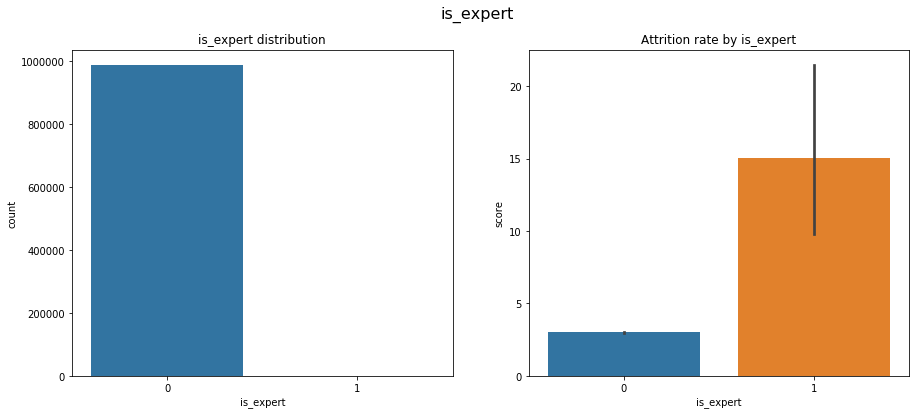

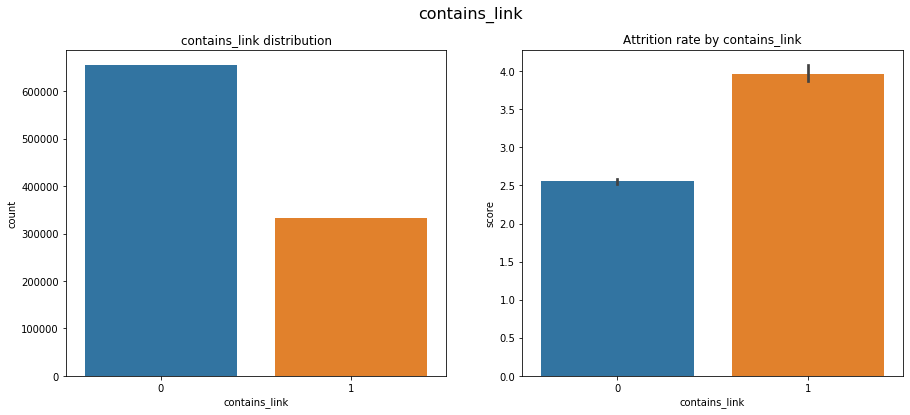

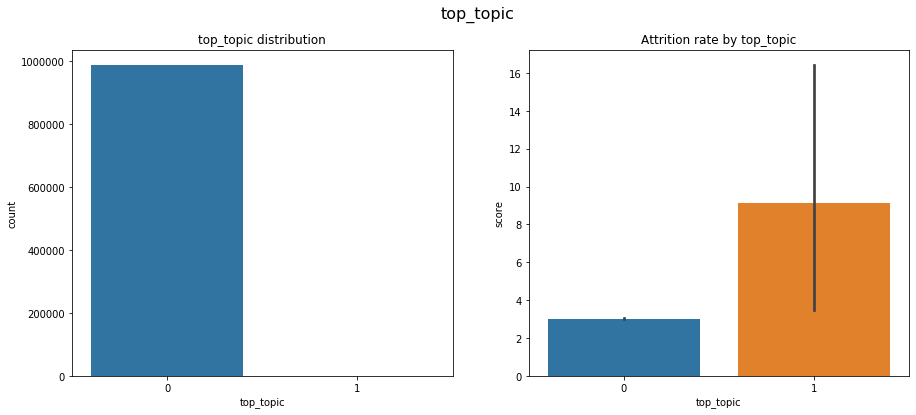

In [32]:
def cat_distribution_target_proportion(column):
    fig , axes = plt.subplots(1,2,figsize = (15,6))
    fig.suptitle(column,fontsize=16)
    
    sns.countplot(df[column],ax=axes[0])
    axes[0].set_title(column + ' distribution')
    
    sns.barplot(x=column,y='score',data=df,ax=axes[1])
    axes[1].set_title('Attrition rate by '+column)
    

for col in categorical_cols:
    cat_distribution_target_proportion(col)

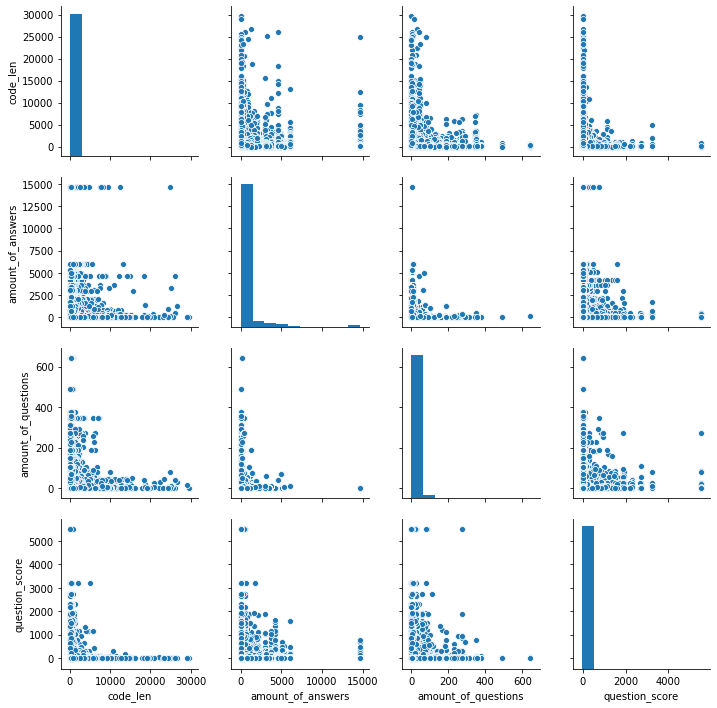

In [33]:
sns.pairplot(data=df[num_cols]);


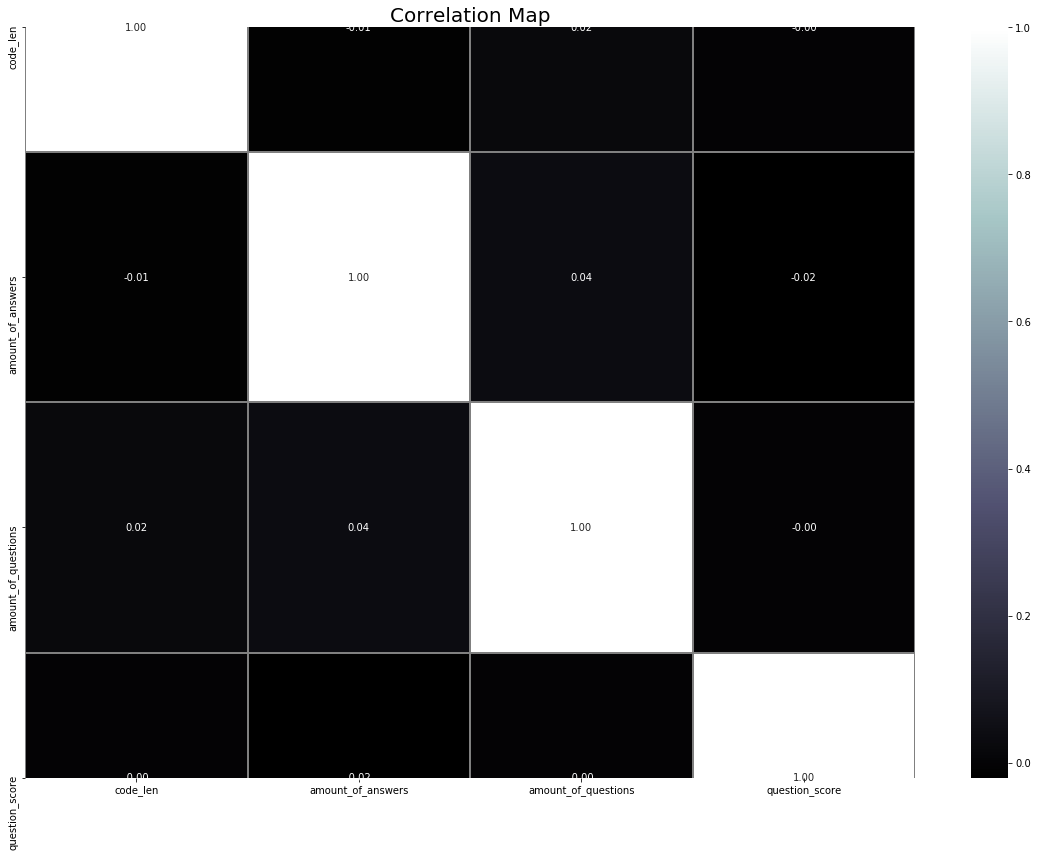

In [36]:
plt.figure(figsize=(16,12))
sns.heatmap(data=df[num_cols].corr(),annot=True,cmap="bone",linewidths=1,fmt=".2f",linecolor="gray")
plt.title("Correlation Map",fontsize=20)
plt.tight_layout()
plt.show() 

## Data preprocessing

In [37]:
from sklearn.model_selection import train_test_split, cross_val_score  

X, X_holdout, y_train,  y_holdout = train_test_split(
    df.drop(columns='score'),
    df['score'], 
    test_size=0.3,
    shuffle = False
)

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

tf_id_vectorizer = TfidfVectorizer(
        stop_words=stopwords.words('english'),
        ngram_range=(1,2),
        max_features=50000
)
    
X_body_vectorized = tf_id_vectorizer.fit_transform(X['body'])
X_holdout_body_vectorized = tf_id_vectorizer.transform(X_holdout['body'])

## Prediction for hold-out and test samples

### Linear models

In [39]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_numeric_scaled = sc.fit_transform(X[num_cols])
X_holdout_numeric_scaled = sc.transform(X_holdout[num_cols])

In [40]:
X_train = hstack([X[categorical_cols], X_numeric_scaled, X_body_vectorized])
X_test = hstack([X_holdout[categorical_cols], X_holdout_numeric_scaled, X_holdout_body_vectorized])

In [41]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

params = {'alpha': [0.1, 1.0, 10]}

linear_cvs = []
for e in [Ridge(), Lasso()]:
    cv = GridSearchCV(estimator=e, param_grid=params, n_jobs=-1, scoring=make_scorer(mean_absolute_error))
    cv.fit(X_train, y_train)
    linear_cvs.append(cv)

In [42]:
map(lambda cv: cv.best_estimator_, linear_cvs);

In [43]:
[cv.best_score_ for cv in linear_cvs]

[6.506058816254398, 4.457138172032709]

In [44]:
[mean_absolute_error(y_holdout, cv.predict(X_test)) for cv in linear_cvs]

[4.876119232243078, 3.0299428077982027]

### XGBoost

In [45]:
X_train = hstack([X[categorical_cols], X[num_cols], X_body_vectorized])
X_test = hstack([X_holdout[categorical_cols], X_holdout[num_cols], X_holdout_body_vectorized])

In [46]:
from xgboost import XGBRegressor

xg_reg = XGBRegressor()
xg_reg.fit(X_train, y_train)

[15:04:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
mean_absolute_error(xg_reg.predict(X_test), y_holdout)

2.0768754127809874

In [ ]:
from xgboost import XGBRegressor

params = {
    'max_depth': [int(d) for d in np.linspace(3, 10, 3)],
    'learning_rate': [int(r) for r in np.linspace(0.01, 0.2, 3)],
    'min_child_weight': [1, 2]
}

xg_cv = GridSearchCV (
        estimator = XGBRegressor(nthread=-1),
        param_grid = params,
        scoring=make_scorer(mean_absolute_error),
        n_jobs=-1
)

xg_cv.fit(X_train, y_train)

In [ ]:
predictions = xg_cv.best_estimator_.predict(X_test)

In [ ]:
mean_absolute_error(predictions, y_holdout)